## 前期准备

### 导入相关工具包

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
sns.set(palette="muted", color_codes=True)
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

### 读取数据

In [2]:
df = pd.read_csv(".\数据集\TrainingData.csv", header=0)
df.head()

,Quote_Id,Quote_Date,Quote_Flag,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,...,Property_info1,Property_info2,Property_info3,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5
0,2,14/5/14,0,B,0.9153,935,N,5,2,D,...,N,0,D,1,6,2,13,-1,N,CA
1,3,19/6/13,0,J,0.9691,"1,165",N,5,22,F,...,N,0,D,1,8,14,7,-1,N,TX
2,6,6/2/15,0,B,0.9153,935,N,6,22,D,...,N,0,D,1,11,2,12,-1,N,CA
3,9,15/10/14,0,J,0.8793,"1,113",N,1,22,F,...,N,0,O,0,1,14,6,-1,N,TX
4,10,30/3/15,1,F,1.0101,548,N,13,22,E,...,N,0,R,1,25,4,22,-1,N,NJ


### dataframe压缩

In [3]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df

In [4]:
#dataframe压缩
df=reduce_mem(df)

14.32 Mb, 7.28 Mb (49.17 %)


## day1:基本分析

### 整体情况

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62580 entries, 0 to 62579
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quote_Id          62580 non-null  int32  
 1   Quote_Date        62580 non-null  object 
 2   Quote_Flag        62580 non-null  int8   
 3   Field_info1       62580 non-null  object 
 4   Field_info2       62580 non-null  float16
 5   Field_info3       62580 non-null  object 
 6   Field_info4       62580 non-null  object 
 7   Coverage_info1    62580 non-null  int8   
 8   Coverage_info2    62580 non-null  int8   
 9   Coverage_info3    62580 non-null  object 
 10  Sales_info1       62580 non-null  int8   
 11  Sales_info2       62580 non-null  int8   
 12  Sales_info3       62580 non-null  int8   
 13  Sales_info4       62580 non-null  object 
 14  Sales_info5       62580 non-null  int32  
 15  Personal_info1    62557 non-null  object 
 16  Personal_info2    62580 non-null  int8  

In [6]:
df1=df.copy()
df1.drop('Quote_Date',axis=1,inplace=True)

In [7]:
for col in df.columns:
    print(col)

Quote_Id
Quote_Date
Quote_Flag
Field_info1
Field_info2
Field_info3
Field_info4
Coverage_info1
Coverage_info2
Coverage_info3
Sales_info1
Sales_info2
Sales_info3
Sales_info4
Sales_info5
Personal_info1
Personal_info2
Personal_info3
Personal_info4
Personal_info5
Property_info1
Property_info2
Property_info3
Property_info4
Property_info5
Geographic_info1
Geographic_info2
Geographic_info3
Geographic_info4
Geographic_info5


In [8]:
df['Quote_Date']

0         14/5/14
1         19/6/13
2          6/2/15
3        15/10/14
4         30/3/15
           ...   
62575     28/6/13
62576     25/1/14
62577     24/1/14
62578     7/12/14
62579      8/4/14
Name: Quote_Date, Length: 62580, dtype: object

### 特征相关性

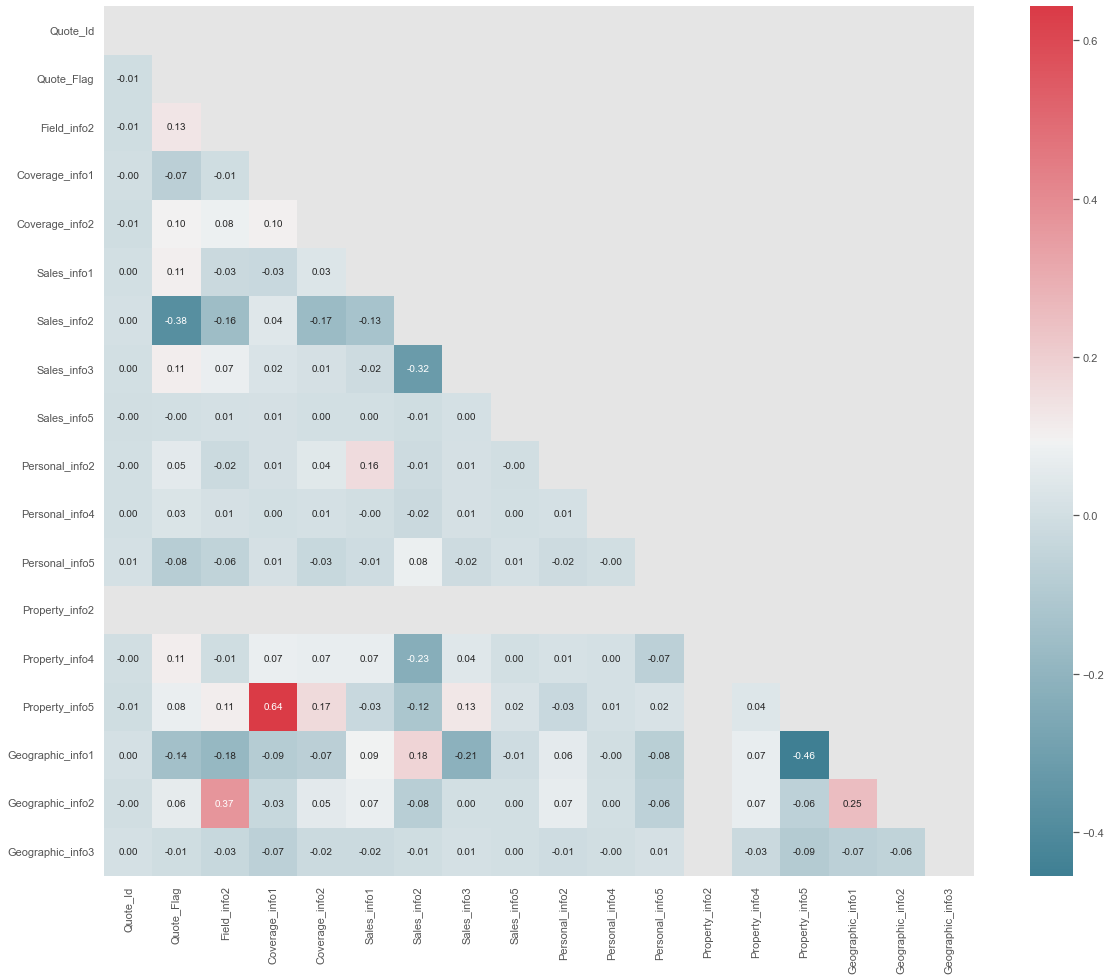

In [9]:
plt.figure(figsize=(20, 16))  
column = df.columns.tolist()  
mcorr = df[column].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True  
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

In [10]:
mcorr=mcorr.abs()
numerical_corr=mcorr[mcorr['Quote_Flag']>0.1]['Quote_Flag']
print(numerical_corr.sort_values(ascending=False))

#index0 = numerical_corr.sort_values(ascending=False).index
#print(traindf[index0].corr('spearman'))

Quote_Flag          1.000000
Sales_info2         0.382022
Geographic_info1    0.144958
Field_info2         0.129336
Property_info4      0.108637
Sales_info3         0.107668
Sales_info1         0.105319
Name: Quote_Flag, dtype: float64


### 查看标签

Quote_Flag
0    50625
1    11955
Name: Quote_Id, dtype: int64正负样本的数量：



<AxesSubplot:xlabel='Quote_Flag', ylabel='count'>

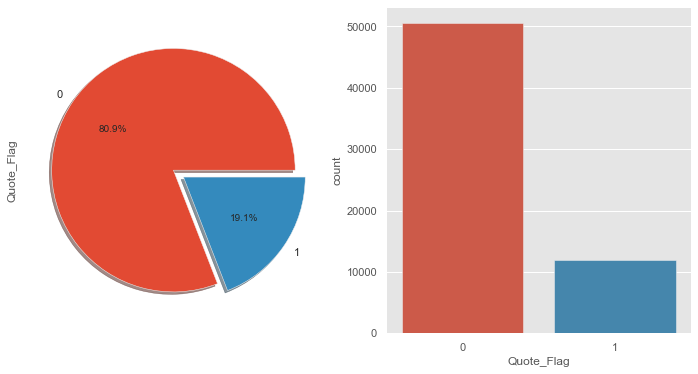

In [11]:
label_gp = df.groupby('Quote_Flag')['Quote_Id'].count()
print('{}正负样本的数量：\n'.format(label_gp))
_,axe = plt.subplots(1,2,figsize=(12,6))
df.Quote_Flag.value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,explode=[0,0.1],ax=axe[0])
sns.countplot('Quote_Flag',data=df,ax=axe[1],)

### 查看缺失值

In [12]:
print(f'There are {df.isnull().any().sum()} columns in train dataset with missing values.')

There are 4 columns in train dataset with missing values.


In [13]:
### 统计缺失值频率大于0.4%的特征
have_null_fea_dict = (df.isnull().sum()/len(df)).to_dict()
fea_null_moreThanHalf = {}
for key,value in have_null_fea_dict.items():
    if value > 0.4:
        fea_null_moreThanHalf[key] = value
fea_null_moreThanHalf

{'Personal_info5': 0.4759987216363055}

<AxesSubplot:>

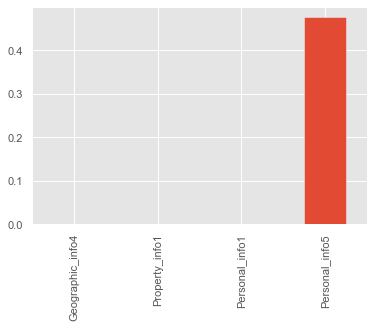

In [14]:
# nan可视化
missing = df.isnull().sum()/len(df)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### 唯一值查看

In [15]:
one_value_fea = [col for col in df.columns if df[col].nunique() <= 1]
one_value_fea

['Property_info2']

### 对象类型

In [16]:
numerical_fea = list(df.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(df.columns)))

In [17]:
numerical_fea,category_fea

(['Quote_Id',
  'Quote_Flag',
  'Field_info2',
  'Coverage_info1',
  'Coverage_info2',
  'Sales_info1',
  'Sales_info2',
  'Sales_info3',
  'Sales_info5',
  'Personal_info2',
  'Personal_info4',
  'Personal_info5',
  'Property_info2',
  'Property_info4',
  'Property_info5',
  'Geographic_info1',
  'Geographic_info2',
  'Geographic_info3'],
 ['Quote_Date',
  'Field_info1',
  'Field_info3',
  'Field_info4',
  'Coverage_info3',
  'Sales_info4',
  'Personal_info1',
  'Personal_info3',
  'Property_info1',
  'Property_info3',
  'Geographic_info4',
  'Geographic_info5'])

In [18]:
df.loc[:,numerical_fea]

,Quote_Id,Quote_Flag,Field_info2,Coverage_info1,Coverage_info2,Sales_info1,Sales_info2,Sales_info3,Sales_info5,Personal_info2,Personal_info4,Personal_info5,Property_info2,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3
0,2,0,0.915527,5,2,1,5,11,55101,-1,0,2.0,0,1,6,2,13,-1
1,3,0,0.969238,5,22,1,5,1,5476,-1,0,NaN,0,1,8,14,7,-1
2,6,0,0.915527,6,22,1,5,11,59655,18,0,2.0,0,1,11,2,12,-1
3,9,0,0.879395,1,22,1,5,11,6943,5,0,2.0,0,0,1,14,6,-1
4,10,1,1.009766,13,22,1,3,20,61148,6,0,NaN,0,1,25,4,22,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,104296,0,0.991699,4,25,0,5,17,38162,7,0,NaN,0,1,16,4,17,-1
62576,104297,0,0.983887,13,2,0,5,20,35716,23,0,2.0,0,1,18,4,19,-1
62577,104299,0,0.940430,7,22,1,4,7,16738,5,0,2.0,0,0,24,2,8,-1
62578,104300,0,0.887207,15,25,1,4,11,4899,-1,0,NaN,0,1,23,14,5,-1


In [19]:
df.loc[:,category_fea]

,Quote_Date,Field_info1,Field_info3,Field_info4,Coverage_info3,Sales_info4,Personal_info1,Personal_info3,Property_info1,Property_info3,Geographic_info4,Geographic_info5
0,14/5/14,B,935,N,D,T,N,ZA,N,D,N,CA
1,19/6/13,J,"1,165",N,F,P,N,XR,N,D,N,TX
2,6/2/15,B,935,N,D,V,N,ZA,N,D,N,CA
3,15/10/14,J,"1,113",N,F,Q,N,ZA,N,O,N,TX
4,30/3/15,F,548,N,E,K,N,XD,N,R,N,NJ
...,...,...,...,...,...,...,...,...,...,...,...,...
62575,28/6/13,F,564,N,J,V,N,XR,N,R,N,NJ
62576,25/1/14,F,548,N,E,R,N,XM,N,R,N,NJ
62577,24/1/14,B,935,N,E,V,N,ZA,N,D,N,CA
62578,7/12/14,J,"1,113",N,G,T,N,ZH,N,J,N,TX


发现Field_info3为数值型变量，因带有千分位号，因此需要变换处理方式

In [20]:
df['Field_info3'] = df['Field_info3'].str.replace(',', '').astype(float)

In [21]:
numerical_fea = list(df.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(df.columns)))
numerical_fea,category_fea

(['Quote_Id',
  'Quote_Flag',
  'Field_info2',
  'Field_info3',
  'Coverage_info1',
  'Coverage_info2',
  'Sales_info1',
  'Sales_info2',
  'Sales_info3',
  'Sales_info5',
  'Personal_info2',
  'Personal_info4',
  'Personal_info5',
  'Property_info2',
  'Property_info4',
  'Property_info5',
  'Geographic_info1',
  'Geographic_info2',
  'Geographic_info3'],
 ['Quote_Date',
  'Field_info1',
  'Field_info4',
  'Coverage_info3',
  'Sales_info4',
  'Personal_info1',
  'Personal_info3',
  'Property_info1',
  'Property_info3',
  'Geographic_info4',
  'Geographic_info5'])

In [22]:
category_fea.remove('Quote_Date')

### 类别特征个数

In [23]:
# 特征nunique分布
for cat_fea in category_fea:
    print(cat_fea + "的特征分布如下：")
    print("{}特征有个{}不同的值".format(cat_fea, df[cat_fea].nunique()))
    print(df[cat_fea].value_counts())

Field_info1的特征分布如下：
Field_info1特征有个8不同的值
B    22809
F    16444
J    12371
E     6375
K     3166
C     1342
D       63
A       10
Name: Field_info1, dtype: int64
Field_info4的特征分布如下：
Field_info4特征有个2不同的值
N    58072
Y     4508
Name: Field_info4, dtype: int64
Coverage_info3的特征分布如下：
Coverage_info3特征有个12不同的值
E    20498
D    11840
G     7844
F     7816
K     6519
J     3947
A     3361
B      265
I      153
H      139
C      136
L       62
Name: Coverage_info3, dtype: int64
Sales_info4的特征分布如下：
Sales_info4特征有个7不同的值
K    12037
P    11975
T    10715
Q     9769
V     9224
R     4922
M     3938
Name: Sales_info4, dtype: int64
Personal_info1的特征分布如下：
Personal_info1特征有个2不同的值
N    62265
Y      292
Name: Personal_info1, dtype: int64
Personal_info3的特征分布如下：
Personal_info3特征有个38不同的值
ZA    29837
XR     3623
XM     2368
XJ     2344
XD     1905
XX     1887
XH     1794
XO     1713
XB     1624
YH     1573
ZH     1312
ZT     1275
ZF     1153
XS     1075
ZR     1071
ZN     1058
YF      927
YE      736
ZG      729

### 类别特征可视化

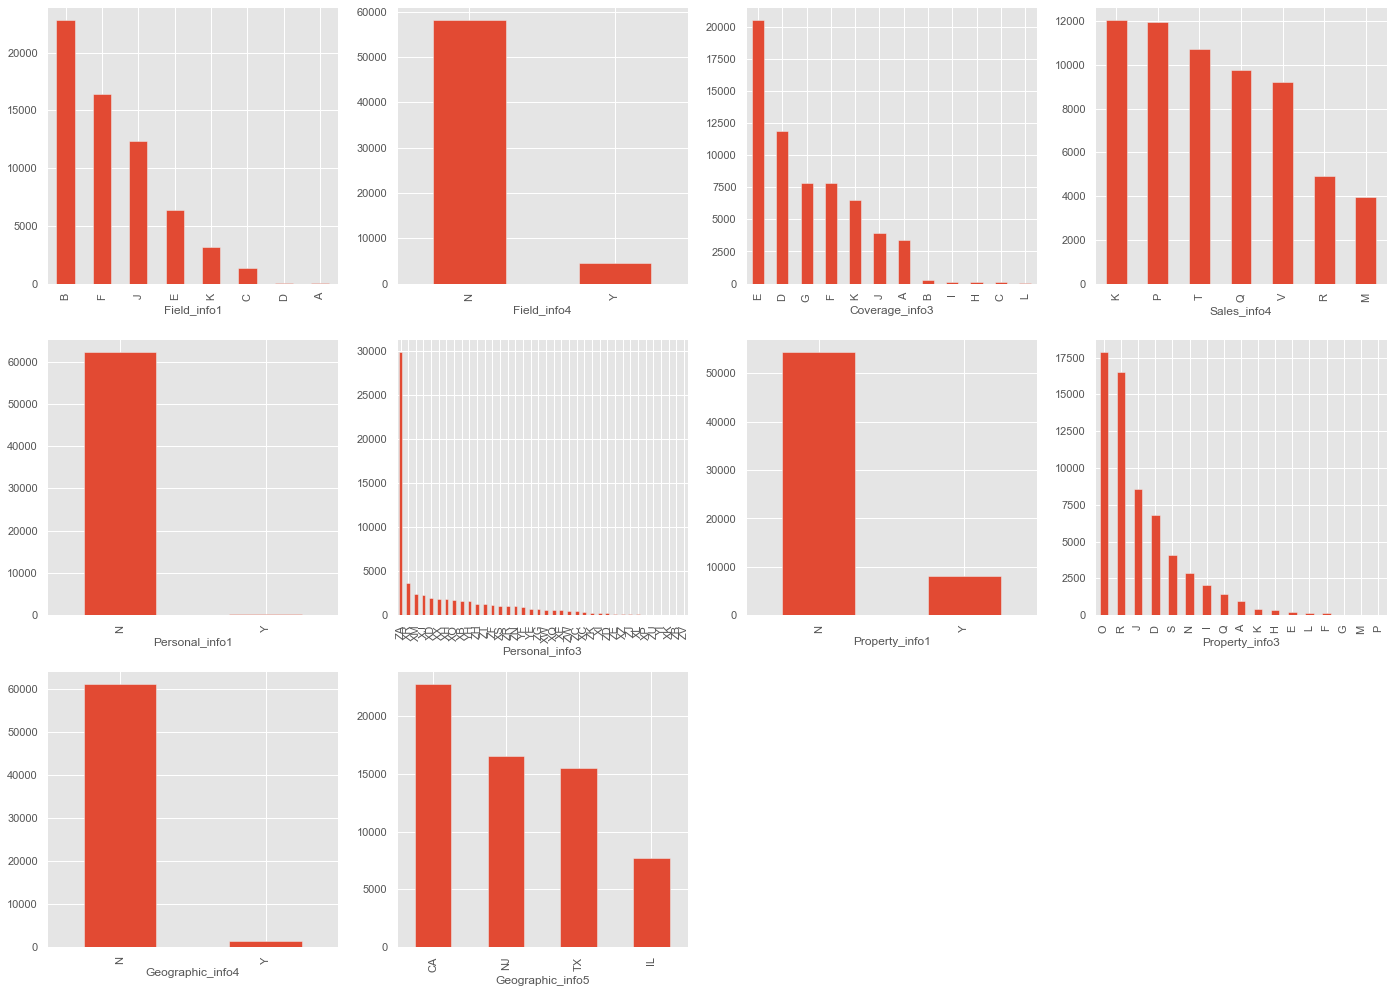

In [24]:
##类别型变量：条形图
dist_cols=4
dist_rows=len(category_fea)
plt.figure(figsize=(6*dist_cols,6*dist_rows))
i=1
for col in category_fea:
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax=df[col].value_counts().plot(kind='bar')
    ax.set_xlabel(col)
    i+=1
plt.show()

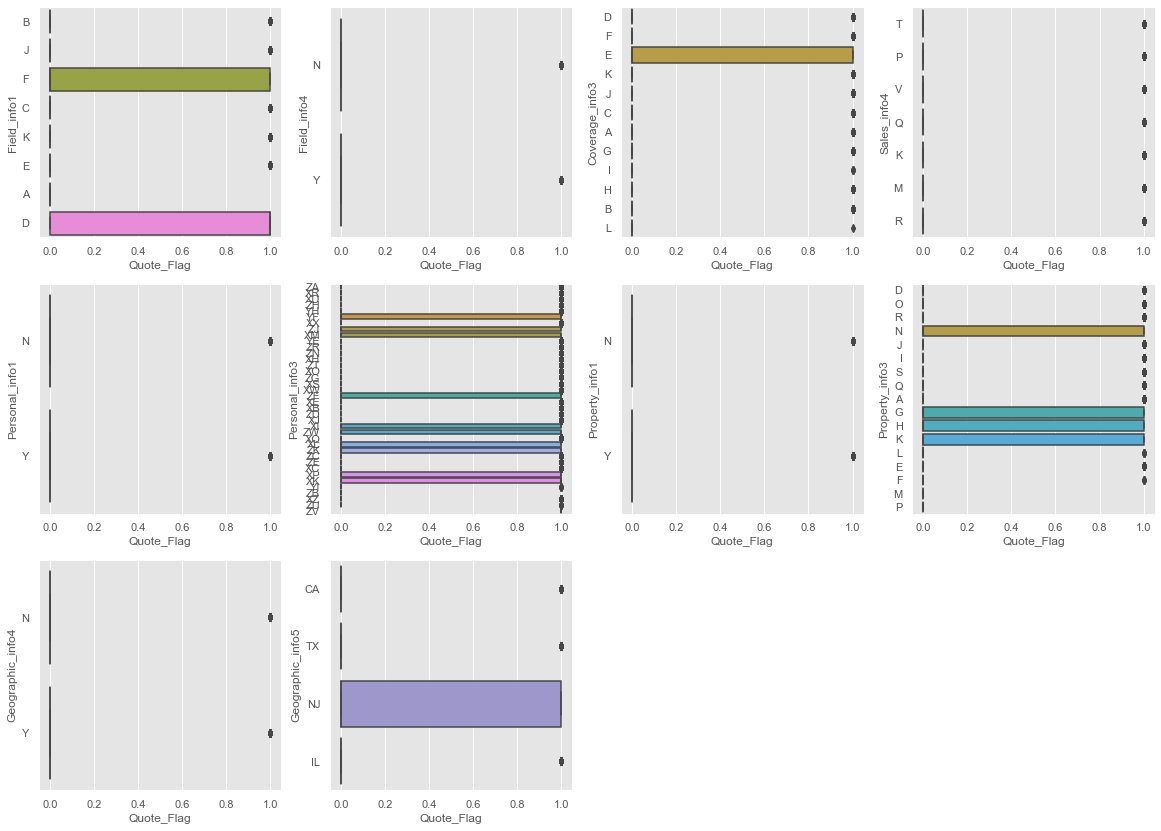

In [25]:
##类别型变量：条形图
dist_cols=4
dist_rows=len(category_fea)
plt.figure(figsize=(5*dist_cols,5*dist_rows))
i=1
for col in category_fea:
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax=sns.boxplot(y=col,x='Quote_Flag',data=df)
    ax.set_ylabel(col)
    i+=1
plt.show()

<AxesSubplot:xlabel='Field_info2', ylabel='count'>

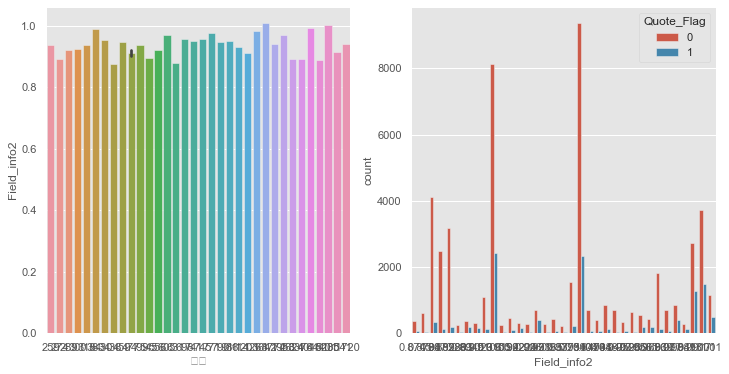

In [26]:
###特征
#查看类型比例
class_gp = df.groupby('Field_info2')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Field_info2',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Field_info4', ylabel='count'>

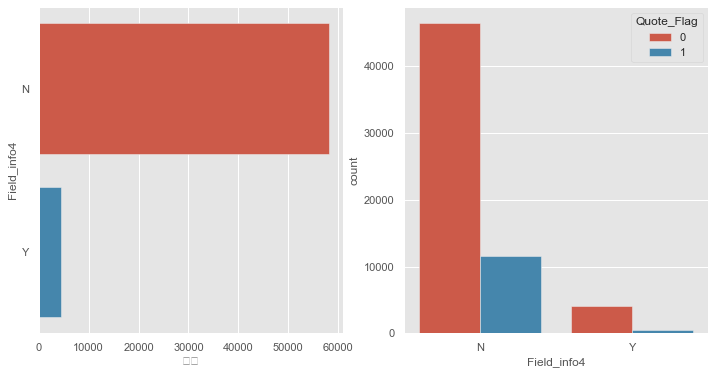

In [27]:
###特征
#查看类型比例
class_gp = df.groupby('Field_info4')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Field_info4',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Coverage_info3', ylabel='count'>

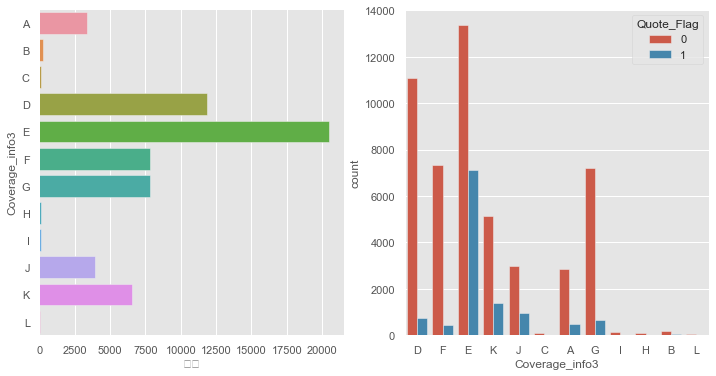

In [28]:
###特征
#查看类型比例
class_gp = df.groupby('Coverage_info3')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Coverage_info3',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Personal_info1', ylabel='count'>

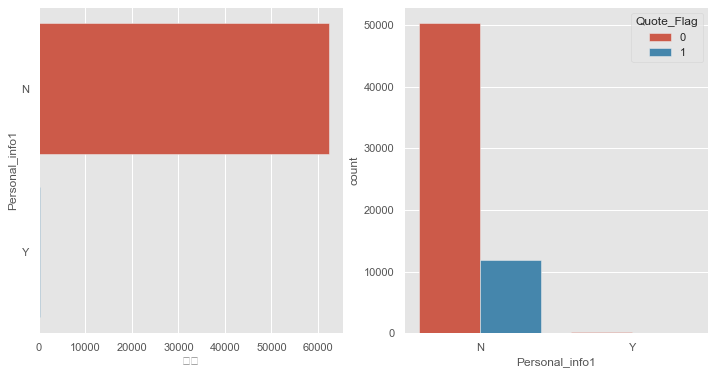

In [29]:
###特征
#查看类型比例
class_gp = df.groupby('Personal_info1')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Personal_info1',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Sales_info4', ylabel='count'>

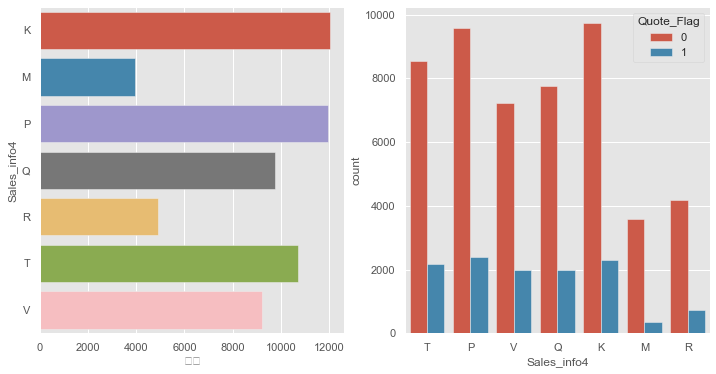

In [30]:
###特征
#查看类型比例
class_gp = df.groupby('Sales_info4')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Sales_info4',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Personal_info3', ylabel='count'>

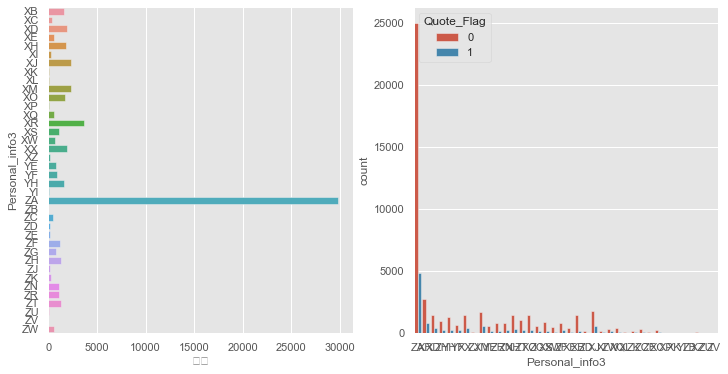

In [31]:
###特征
#查看类型比例
class_gp = df.groupby('Personal_info3')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Personal_info3',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Sales_info4', ylabel='count'>

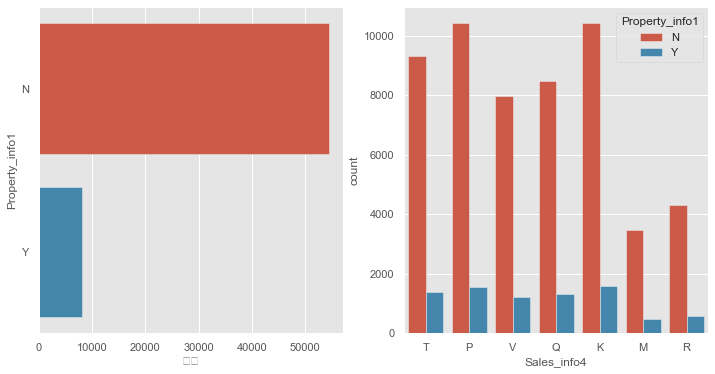

In [32]:
###特征
#查看类型比例
class_gp = df.groupby('Property_info1')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Sales_info4',hue='Property_info1',data=df,ax=axe[1])

<AxesSubplot:xlabel='Property_info3', ylabel='count'>

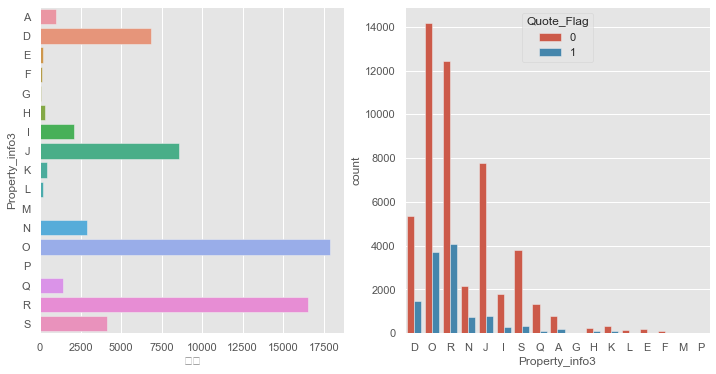

In [33]:
###特征
#查看类型比例
class_gp = df.groupby('Property_info3')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Property_info3',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Geographic_info4', ylabel='count'>

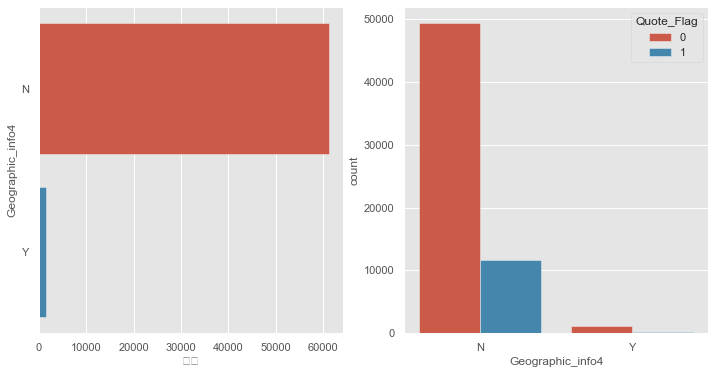

In [34]:
###特征
#查看类型比例
class_gp = df.groupby('Geographic_info4')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Geographic_info4',hue='Quote_Flag',data=df,ax=axe[1])

<AxesSubplot:xlabel='Geographic_info5', ylabel='count'>

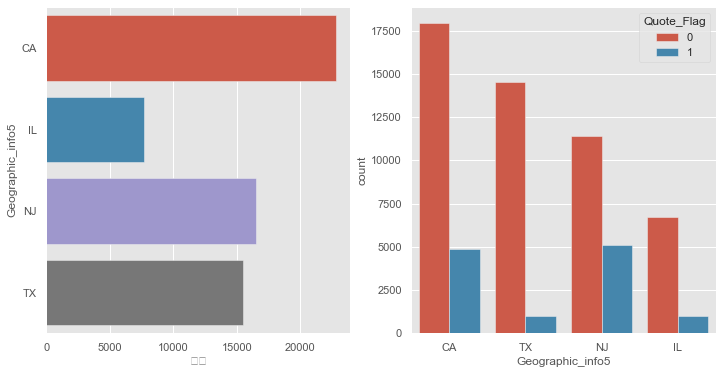

In [35]:
###特征
#查看类型比例
class_gp = df.groupby('Geographic_info5')['Quote_Id'].count()
class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
class_gp.columns={'数量','比例'}
###画图可视化
_,axe = plt.subplots(1,2,figsize=(12,6))
sns.barplot(x=class_gp['数量'],y=class_gp.index,ax=axe[0])
sns.countplot(x='Geographic_info5',hue='Quote_Flag',data=df,ax=axe[1])

### 过滤数值型类别特征

In [36]:
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(df,numerical_fea)
numerical_serial_fea,numerical_noserial_fea

(['Quote_Id',
  'Field_info2',
  'Coverage_info1',
  'Sales_info3',
  'Sales_info5',
  'Personal_info2',
  'Property_info5',
  'Geographic_info1',
  'Geographic_info2'],
 ['Quote_Flag',
  'Field_info3',
  'Coverage_info2',
  'Sales_info1',
  'Sales_info2',
  'Personal_info4',
  'Personal_info5',
  'Property_info2',
  'Property_info4',
  'Geographic_info3'])

### 小于10类数值特征按

In [37]:
##小于10类的数值特征
df.loc[:,numerical_noserial_fea]

,Quote_Flag,Field_info3,Coverage_info2,Sales_info1,Sales_info2,Personal_info4,Personal_info5,Property_info2,Property_info4,Geographic_info3
0,0,935.0,2,1,5,0,2.0,0,1,-1
1,0,1165.0,22,1,5,0,NaN,0,1,-1
2,0,935.0,22,1,5,0,2.0,0,1,-1
3,0,1113.0,22,1,5,0,2.0,0,0,-1
4,1,548.0,22,1,3,0,NaN,0,1,-1
...,...,...,...,...,...,...,...,...,...,...
62575,0,564.0,25,0,5,0,NaN,0,1,-1
62576,0,548.0,2,0,5,0,2.0,0,1,-1
62577,0,935.0,22,1,4,0,2.0,0,0,-1
62578,0,1113.0,25,1,4,0,NaN,0,1,-1


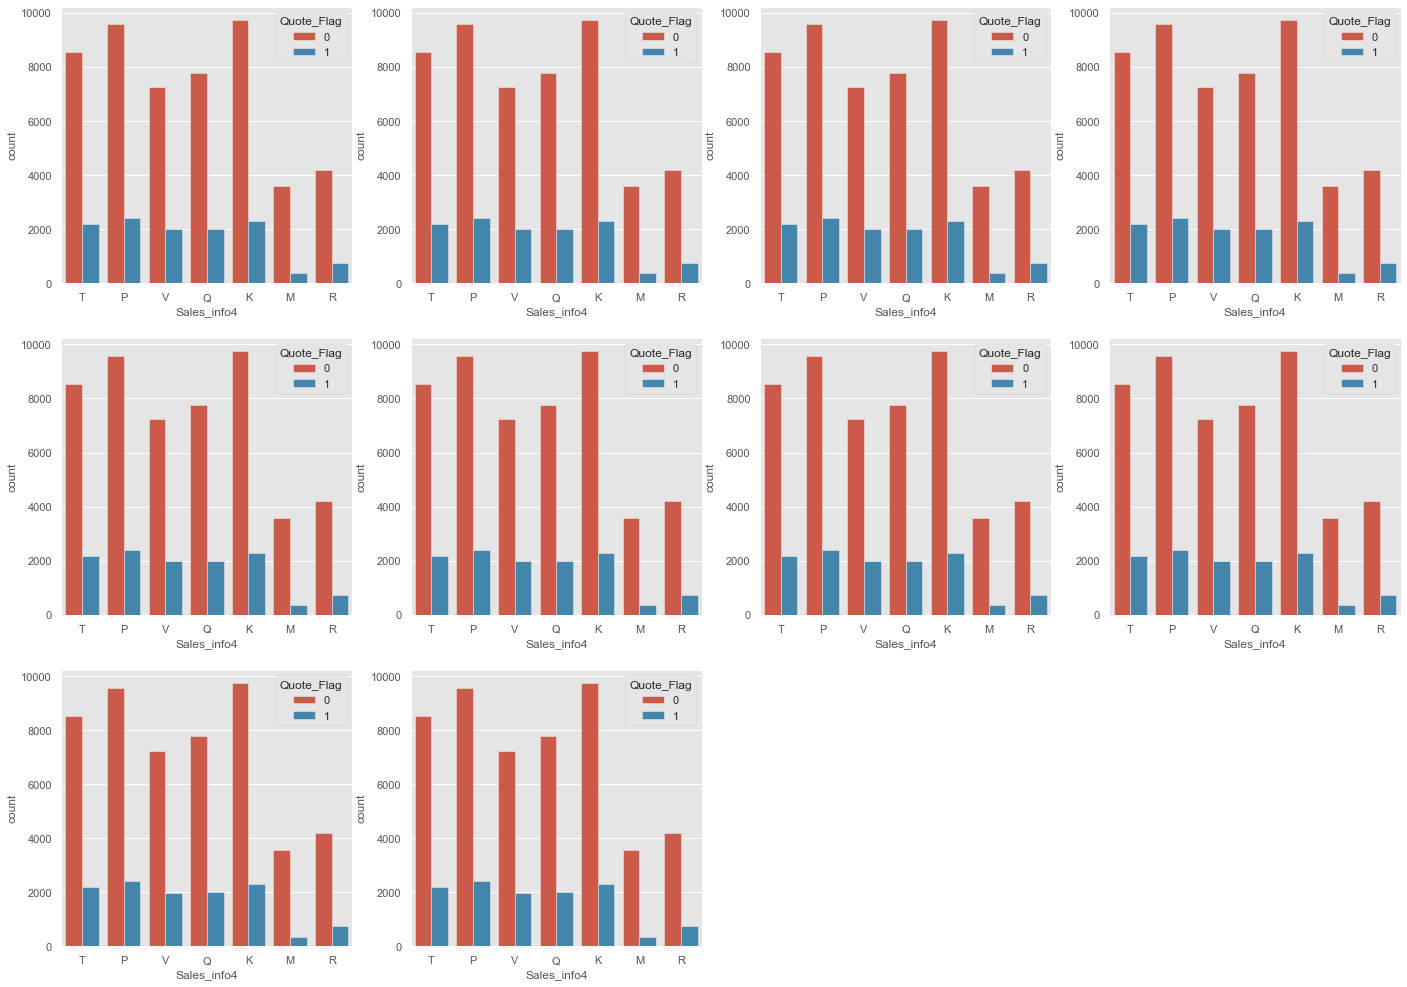

In [38]:
i=1
dist_cols=4
dist_rows=len(category_fea)
plt.figure(figsize=(6*dist_cols,6*dist_rows))
for col in numerical_noserial_fea:
    class_gp = df.groupby(col)['Quote_Id'].count()
    class_gp=pd.concat([class_gp,class_gp/len(df)],axis=1)
    class_gp.columns={'数量','比例'}
    ###画图可视化
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax.set_xlabel(col)
    ax.set_ylabel('count')
    sns.countplot(x='Sales_info4',hue='Quote_Flag',data=df)
    i+=1
plt.show()

### 大于10类的数值特征

In [39]:
##大于10类的数值特征
df.loc[:,numerical_serial_fea]

,Quote_Id,Field_info2,Coverage_info1,Sales_info3,Sales_info5,Personal_info2,Property_info5,Geographic_info1,Geographic_info2
0,2,0.915527,5,11,55101,-1,6,2,13
1,3,0.969238,5,1,5476,-1,8,14,7
2,6,0.915527,6,11,59655,18,11,2,12
3,9,0.879395,1,11,6943,5,1,14,6
4,10,1.009766,13,20,61148,6,25,4,22
...,...,...,...,...,...,...,...,...,...
62575,104296,0.991699,4,17,38162,7,16,4,17
62576,104297,0.983887,13,20,35716,23,18,4,19
62577,104299,0.940430,7,7,16738,5,24,2,8
62578,104300,0.887207,15,11,4899,-1,23,14,5


In [40]:
##数值型变量统计信息
##大于10类的数值特征
df.loc[:,numerical_serial_fea].describe()

,Quote_Id,Field_info2,Coverage_info1,Sales_info3,Sales_info5,Personal_info2,Property_info5,Geographic_info1,Geographic_info2
count,62580.000000,62580.000000,62580.000000,62580.000000,62580.000000,62580.000000,62580.000000,62580.000000,62580.000000
mean,52125.978923,0.938477,8.999057,13.992410,33738.501135,6.905225,12.985874,7.381192,13.267370
std,30130.035087,0.037018,5.575434,6.296919,19521.641287,6.727773,7.210242,7.076647,6.864138
min,2.000000,0.874512,-1.000000,1.000000,4.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,25980.750000,0.915527,5.000000,11.000000,16776.750000,4.000000,7.000000,2.000000,7.000000
50%,51989.000000,0.940430,8.000000,11.000000,33912.000000,6.000000,13.000000,4.000000,13.000000
75%,78291.500000,0.968262,12.000000,20.000000,50734.250000,9.000000,19.000000,11.000000,19.000000
max,104301.000000,1.009766,25.000000,24.000000,67162.000000,25.000000,25.000000,25.000000,25.000000


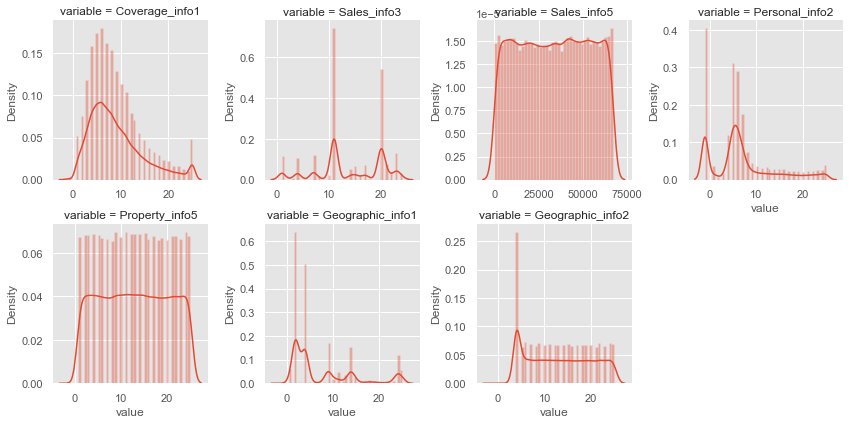

In [41]:
#每个数字特征得分布可视化
f = pd.melt(df, value_vars=numerical_serial_fea[2:])
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [42]:
### 对于sales_indo5考虑分箱处理

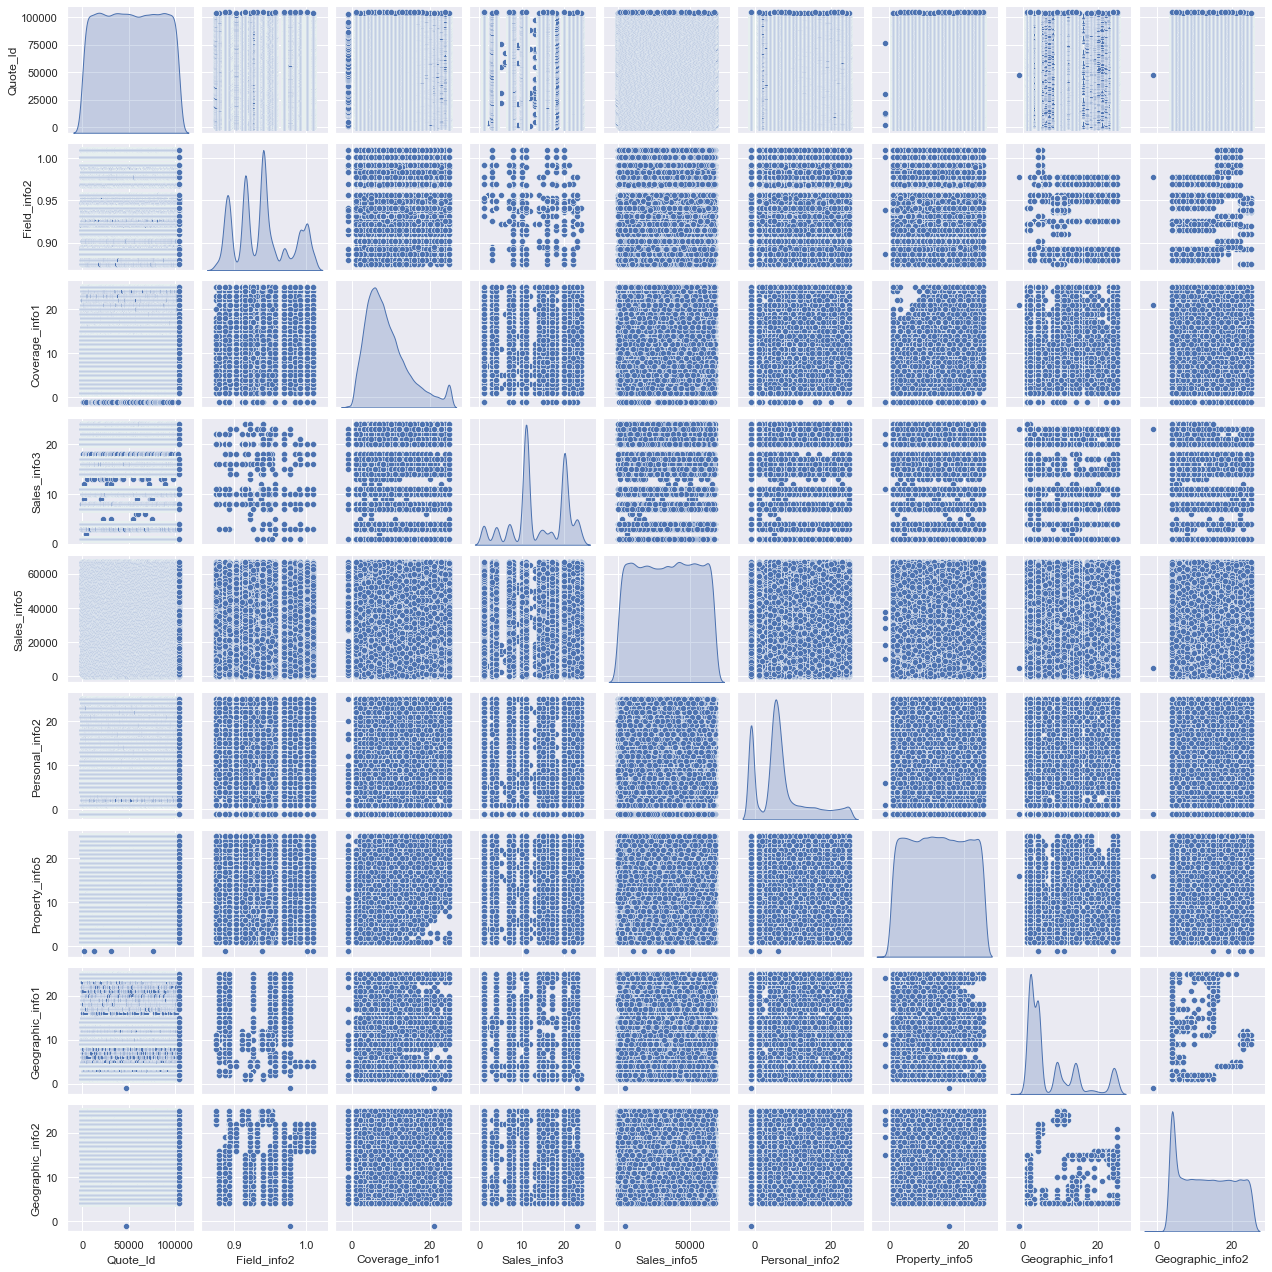

In [43]:
## 4) 数字特征相互之间的关系可视化
sns.set()
columns = numerical_serial_fea
sns.pairplot(df[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

### 日期变量处理

In [44]:
# 日期类型：issueDate，earliesCreditLine
#train[cat_features]
# 转换为pandas中的日期类型
import datetime
df['Quote_Date'] = pd.to_datetime(df['Quote_Date'])
# 提取多尺度特征
df['Quote_date_y'] = df['Quote_Date'].dt.year
df['Quote_date_m'] = df['Quote_Date'].dt.month
# 提取时间diff
# 设置初始的时间
base_time = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
# 转换为天为单位
df['Quote_date_diff'] = df['Quote_Date'].apply(lambda x: x-base_time).dt.days
df.drop('Quote_Date', axis = 1, inplace = True)

## day2 缺失值异常值分析

### 缺失值统计

In [45]:
df.isnull().sum()

Quote_Id                0
Quote_Flag              0
Field_info1             0
Field_info2             0
Field_info3             0
Field_info4             0
Coverage_info1          0
Coverage_info2          0
Coverage_info3          0
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info4             0
Sales_info5             0
Personal_info1         23
Personal_info2          0
Personal_info3          0
Personal_info4          0
Personal_info5      29788
Property_info1         16
Property_info2          0
Property_info3          0
Property_info4          0
Property_info5          0
Geographic_info1        0
Geographic_info2        0
Geographic_info3        0
Geographic_info4        1
Geographic_info5        0
Quote_date_y            0
Quote_date_m            0
Quote_date_diff         0
dtype: int64

In [46]:
### 统计缺失值频率大于0.1的特征
have_null_fea_dict = (df.isnull().sum()/len(df)).to_dict()
fea_null_moreThanHalf = {}
for key,value in have_null_fea_dict.items():
    if value > 0.1:
        fea_null_moreThanHalf[key] = value
fea_null_moreThanHalf

{'Personal_info5': 0.4759987216363055}

In [47]:
dfnull=df.isnull().sum()[df.isnull().sum()>0]
dfnull.drop('Personal_info5',inplace=True)

### 缺失值处理

In [48]:
df.dropna(axis=0,subset = dfnull.index,inplace = True)
df.isnull().sum()

Quote_Id                0
Quote_Flag              0
Field_info1             0
Field_info2             0
Field_info3             0
Field_info4             0
Coverage_info1          0
Coverage_info2          0
Coverage_info3          0
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info4             0
Sales_info5             0
Personal_info1          0
Personal_info2          0
Personal_info3          0
Personal_info4          0
Personal_info5      29780
Property_info1          0
Property_info2          0
Property_info3          0
Property_info4          0
Property_info5          0
Geographic_info1        0
Geographic_info2        0
Geographic_info3        0
Geographic_info4        0
Geographic_info5        0
Quote_date_y            0
Quote_date_m            0
Quote_date_diff         0
dtype: int64

In [49]:
df['Personal_info5'].value_counts()

2.0    32377
1.0      364
5.0       18
3.0        1
Name: Personal_info5, dtype: int64

In [50]:
df['Personal_info5'].fillna(4.0,inplace=True)

In [51]:
df.isnull().sum()

Quote_Id            0
Quote_Flag          0
Field_info1         0
Field_info2         0
Field_info3         0
Field_info4         0
Coverage_info1      0
Coverage_info2      0
Coverage_info3      0
Sales_info1         0
Sales_info2         0
Sales_info3         0
Sales_info4         0
Sales_info5         0
Personal_info1      0
Personal_info2      0
Personal_info3      0
Personal_info4      0
Personal_info5      0
Property_info1      0
Property_info2      0
Property_info3      0
Property_info4      0
Property_info5      0
Geographic_info1    0
Geographic_info2    0
Geographic_info3    0
Geographic_info4    0
Geographic_info5    0
Quote_date_y        0
Quote_date_m        0
Quote_date_diff     0
dtype: int64

### 异常值分析

In [52]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [53]:
# #data_train = data_train.copy()

# for fea in numerical_fea:
#     df = find_outliers_by_3segama(df,fea)
#     print(df[fea+'_outliers'].value_counts())
#     print(df.groupby(fea+'_outliers')['Quote_Flag'].sum())
#     print('*'*10)

In [54]:
# #删除异常值
# for fea in numerical_fea:
#     df = df[df[fea+'_outliers']=='正常值']
#     df = df.reset_index(drop=True) 
##这块暂时没处理，后续模型之后再做

### 数据分桶

In [55]:
# bin = [i*10 for i in range(31)]
# df['Sales_info5 _bin'] = pd.cut(df['Sales_info5'], bin, labels=False)
# df[['Sales_info5 _bin', 'Sales_info5']]
#尝试后效果不太号好,就放弃啦

### 删除唯一值

In [56]:
df.drop(columns='Property_info2',inplace=True)

In [57]:
df

,Quote_Id,Quote_Flag,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,Sales_info1,...,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5,Quote_date_y,Quote_date_m,Quote_date_diff
0,2,0,B,0.915527,935.0,N,5,2,D,1,...,1,6,2,13,-1,N,CA,2014,5,2539
1,3,0,J,0.969238,1165.0,N,5,22,F,1,...,1,8,14,7,-1,N,TX,2013,6,2210
2,6,0,B,0.915527,935.0,N,6,22,D,1,...,1,11,2,12,-1,N,CA,2015,6,2923
3,9,0,J,0.879395,1113.0,N,1,22,F,1,...,0,1,14,6,-1,N,TX,2014,10,2693
4,10,1,F,1.009766,548.0,N,13,22,E,1,...,1,25,4,22,-1,N,NJ,2015,3,2859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,104296,0,F,0.991699,564.0,N,4,25,J,0,...,1,16,4,17,-1,N,NJ,2013,6,2219
62576,104297,0,F,0.983887,548.0,N,13,2,E,0,...,1,18,4,19,-1,N,NJ,2014,1,2430
62577,104299,0,B,0.940430,935.0,N,7,22,E,1,...,0,24,2,8,-1,N,CA,2014,1,2429
62578,104300,0,J,0.887207,1113.0,N,15,25,G,1,...,1,23,14,5,-1,N,TX,2014,7,2598


## day3 初步训练

### 选取数据

### 选择数值型数据训练

In [58]:
numerical_fea = list(df.select_dtypes(exclude=['object']).columns)
df_num=df.loc[:,numerical_fea]
df_num

,Quote_Id,Quote_Flag,Field_info2,Field_info3,Coverage_info1,Coverage_info2,Sales_info1,Sales_info2,Sales_info3,Sales_info5,...,Personal_info4,Personal_info5,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Quote_date_y,Quote_date_m,Quote_date_diff
0,2,0,0.915527,935.0,5,2,1,5,11,55101,...,0,2.0,1,6,2,13,-1,2014,5,2539
1,3,0,0.969238,1165.0,5,22,1,5,1,5476,...,0,4.0,1,8,14,7,-1,2013,6,2210
2,6,0,0.915527,935.0,6,22,1,5,11,59655,...,0,2.0,1,11,2,12,-1,2015,6,2923
3,9,0,0.879395,1113.0,1,22,1,5,11,6943,...,0,2.0,0,1,14,6,-1,2014,10,2693
4,10,1,1.009766,548.0,13,22,1,3,20,61148,...,0,4.0,1,25,4,22,-1,2015,3,2859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,104296,0,0.991699,564.0,4,25,0,5,17,38162,...,0,4.0,1,16,4,17,-1,2013,6,2219
62576,104297,0,0.983887,548.0,13,2,0,5,20,35716,...,0,2.0,1,18,4,19,-1,2014,1,2430
62577,104299,0,0.940430,935.0,7,22,1,4,7,16738,...,0,2.0,0,24,2,8,-1,2014,1,2429
62578,104300,0,0.887207,1113.0,15,25,1,4,11,4899,...,0,4.0,1,23,14,5,-1,2014,7,2598


In [59]:
X=df_num.loc[:,"Field_info2":"Quote_date_diff"]
Y=df_num['Quote_Flag']

### 划分数据集

In [60]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)

(43778, 19)
(18762, 19)


### 多种模型训练

[21:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.051731
0:	learn: 0.6301091	total: 158ms	remaining: 2m 37s
1:	learn: 0.5793379	total: 173ms	remaining: 1m 26s
2:	learn: 0.5379007	total: 194ms	remaining: 1m 4s
3:	learn: 0.5066614	total: 212ms	remaining: 52.8s
4:	learn: 0.4849042	total: 233ms	remaining: 46.3s
5:	learn: 0.4612796	total: 252ms	remaining: 41.7s
6:	learn: 0.4453298	total: 270ms	remaining: 38.3s
7:	learn: 0.4287313	total: 293ms	remaining: 36.4s
8:	learn: 0.4173953	total: 313ms	remaining: 34.4s
9:	learn: 0.4074267	total: 335ms	remaining: 33.1s
10:	learn: 0.3972397	total: 358ms	remaining: 32.2s
11:	learn: 0.3880371	total: 377ms	remaining: 31.1s
12:	learn: 0.3817015	total: 399ms	remaining: 30.3s
13:	l

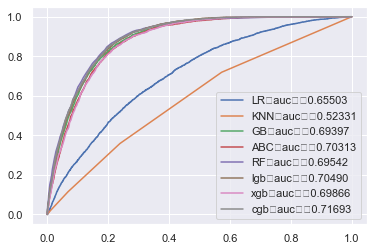

  names    scores  precisions   recalls       f1s      aucs
0    LR  0.601855    0.292754  0.741971  0.419851  0.655032
1   KNN  0.773052    0.288369  0.115015  0.164443  0.523312
2    GB  0.844100    0.640784  0.448531  0.527693  0.693973
3   ABC  0.838717    0.606710  0.481471  0.536884  0.703134
4    RF  0.850123    0.673631  0.442492  0.534129  0.695418
5   lgb  0.847937    0.649508  0.471040  0.546062  0.704896
6   xgb  0.836211    0.598890  0.473785  0.529042  0.698663
7   cgb  0.850709    0.651004  0.498216  0.564453  0.716930


In [61]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb


##设置5折交叉验证
# kfold = StratifiedKFold(n_splits=5)
##添加模型
models = []
models.append(('LR', LogisticRegression(C=1e10, class_weight = 'balanced')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state = 42)))
models.append(('ABC', AdaBoostClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(class_weight = 'balanced')))
models.append(('lgb',lgb.LGBMClassifier()))
models.append(('xgb',xgb.XGBRFClassifier()))
models.append(('cgb',ctb.CatBoostClassifier()))
models.append
names = []
aucs=[]
scores=[]
precisions=[]
recalls=[]
f1s=[]
for name, model in models:
    #cv_results = model_selection.cross_val_score(estimator = model, X = X_train, 
    #                                             y = y_train, cv=kfold, scoring = scoring)
    
    model.fit(X_train, y_train)
    Y_pred_test = model.predict(X_test)
    score=model.score(X_test,y_test)
    scores.append(score)
    precision=precision_score(y_test,Y_pred_test)
    precisions.append(precision)
    recall=recall_score(y_test,Y_pred_test)
    recalls.append(recall)
    f1=f1_score(y_test,Y_pred_test)
    f1s.append(f1)
    fpr, tpr, thresholds= roc_curve(y_test,model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test,model.predict(X_test))
    aucs.append(auc)
    plt.plot(fpr, tpr, label='{}的auc值为{:.5f}'.format(name,auc))
    names.append(name)
    msg = "%s: score:%f (precision:%f,recall:%f)" % (name, score, precision, recall)
plt.legend(loc='lower right')
plt.show()
c={"names":names,"scores":scores,"precisions":precisions,"recalls":recalls,"f1s":f1s,"aucs":aucs}
result=pd.DataFrame(c)
print(result)

### LabelEncoder处理

In [62]:
#类别变量处理
numerical_fea = list(df.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(df.columns)))
category_fea

['Field_info1',
 'Field_info4',
 'Coverage_info3',
 'Sales_info4',
 'Personal_info1',
 'Personal_info3',
 'Property_info1',
 'Property_info3',
 'Geographic_info4',
 'Geographic_info5']

In [63]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
for i in category_fea:
    le.fit(df[i].values)
    df[i]=le.transform(df[i].values)
df

,Quote_Id,Quote_Flag,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,Sales_info1,...,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5,Quote_date_y,Quote_date_m,Quote_date_diff
0,2,0,1,0.915527,935.0,0,5,2,3,1,...,1,6,2,13,-1,0,0,2014,5,2539
1,3,0,6,0.969238,1165.0,0,5,22,5,1,...,1,8,14,7,-1,0,3,2013,6,2210
2,6,0,1,0.915527,935.0,0,6,22,3,1,...,1,11,2,12,-1,0,0,2015,6,2923
3,9,0,6,0.879395,1113.0,0,1,22,5,1,...,0,1,14,6,-1,0,3,2014,10,2693
4,10,1,5,1.009766,548.0,0,13,22,4,1,...,1,25,4,22,-1,0,2,2015,3,2859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,104296,0,5,0.991699,564.0,0,4,25,9,0,...,1,16,4,17,-1,0,2,2013,6,2219
62576,104297,0,5,0.983887,548.0,0,13,2,4,0,...,1,18,4,19,-1,0,2,2014,1,2430
62577,104299,0,1,0.940430,935.0,0,7,22,4,1,...,0,24,2,8,-1,0,0,2014,1,2429
62578,104300,0,6,0.887207,1113.0,0,15,25,6,1,...,1,23,14,5,-1,0,3,2014,7,2598


### 选择所有变量训练

In [64]:
X=df.loc[:,"Field_info1":"Quote_date_diff"]
Y=df['Quote_Flag']

In [65]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)

(43778, 29)
(18762, 29)


[21:04:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.051731
0:	learn: 0.6303168	total: 22.4ms	remaining: 22.4s
1:	learn: 0.5786217	total: 45.3ms	remaining: 22.6s
2:	learn: 0.5454632	total: 67.9ms	remaining: 22.6s
3:	learn: 0.5101628	total: 90.3ms	remaining: 22.5s
4:	learn: 0.4829549	total: 114ms	remaining: 22.7s
5:	learn: 0.4599027	total: 136ms	remaining: 22.5s
6:	learn: 0.4407683	total: 160ms	remaining: 22.7s
7:	learn: 0.4283963	total: 184ms	remaining: 22.8s
8:	learn: 0.4175728	total: 206ms	remaining: 22.6s
9:	learn: 0.4080597	total: 233ms	remaining: 23.1s
10:	learn: 0.3967893	total: 256ms	remaining: 23.1s
11:	learn: 0.3876037	total: 282ms	remaining: 23.2s
12:	learn: 0.3815597	total: 303ms	remaining: 23s
13:	l

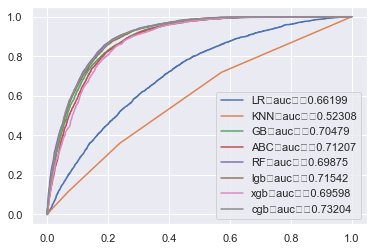

  names    scores  precisions   recalls       f1s      aucs
0    LR  0.596951    0.294105  0.768323  0.425380  0.661991
1   KNN  0.772839    0.287285  0.114741  0.163986  0.523076
2    GB  0.850123    0.661485  0.467197  0.547619  0.704794
3   ABC  0.845219    0.629060  0.494373  0.553643  0.712065
4    RF  0.854653    0.697584  0.443865  0.542526  0.698750
5   lgb  0.854493    0.672720  0.488059  0.565702  0.715423
6   xgb  0.835252    0.596503  0.468295  0.524681  0.695984
7   cgb  0.858277    0.672874  0.525666  0.590230  0.732044


In [66]:

##设置5折交叉验证
# kfold = StratifiedKFold(n_splits=5)
##添加模型
models = []
models.append(('LR', LogisticRegression(C=1e10, class_weight = 'balanced')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state = 42)))
models.append(('ABC', AdaBoostClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(class_weight = 'balanced')))
models.append(('lgb',lgb.LGBMClassifier()))
models.append(('xgb',xgb.XGBRFClassifier()))
models.append(('cgb',ctb.CatBoostClassifier()))
models.append
names = []
aucs=[]
scores=[]
precisions=[]
recalls=[]
f1s=[]
for name, model in models:
    #cv_results = model_selection.cross_val_score(estimator = model, X = X_train, 
    #                                             y = y_train, cv=kfold, scoring = scoring)
    
    model.fit(X_train, y_train)
    Y_pred_test = model.predict(X_test)
    score=model.score(X_test,y_test)
    scores.append(score)
    precision=precision_score(y_test,Y_pred_test)
    precisions.append(precision)
    recall=recall_score(y_test,Y_pred_test)
    recalls.append(recall)
    f1=f1_score(y_test,Y_pred_test)
    f1s.append(f1)
    fpr, tpr, thresholds= roc_curve(y_test,model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test,model.predict(X_test))
    aucs.append(auc)
    plt.plot(fpr, tpr, label='{}的auc值为{:.5f}'.format(name,auc))
    names.append(name)
    msg = "%s: score:%f (precision:%f,recall:%f)" % (name, score, precision, recall)
plt.legend(loc='lower right')
plt.show()
c={"names":names,"scores":scores,"precisions":precisions,"recalls":recalls,"f1s":f1s,"aucs":aucs}
result=pd.DataFrame(c)
print(result)

In [67]:
## 精度有所下降需要选择合适特征

## day4 最终

### 相关性查看特征

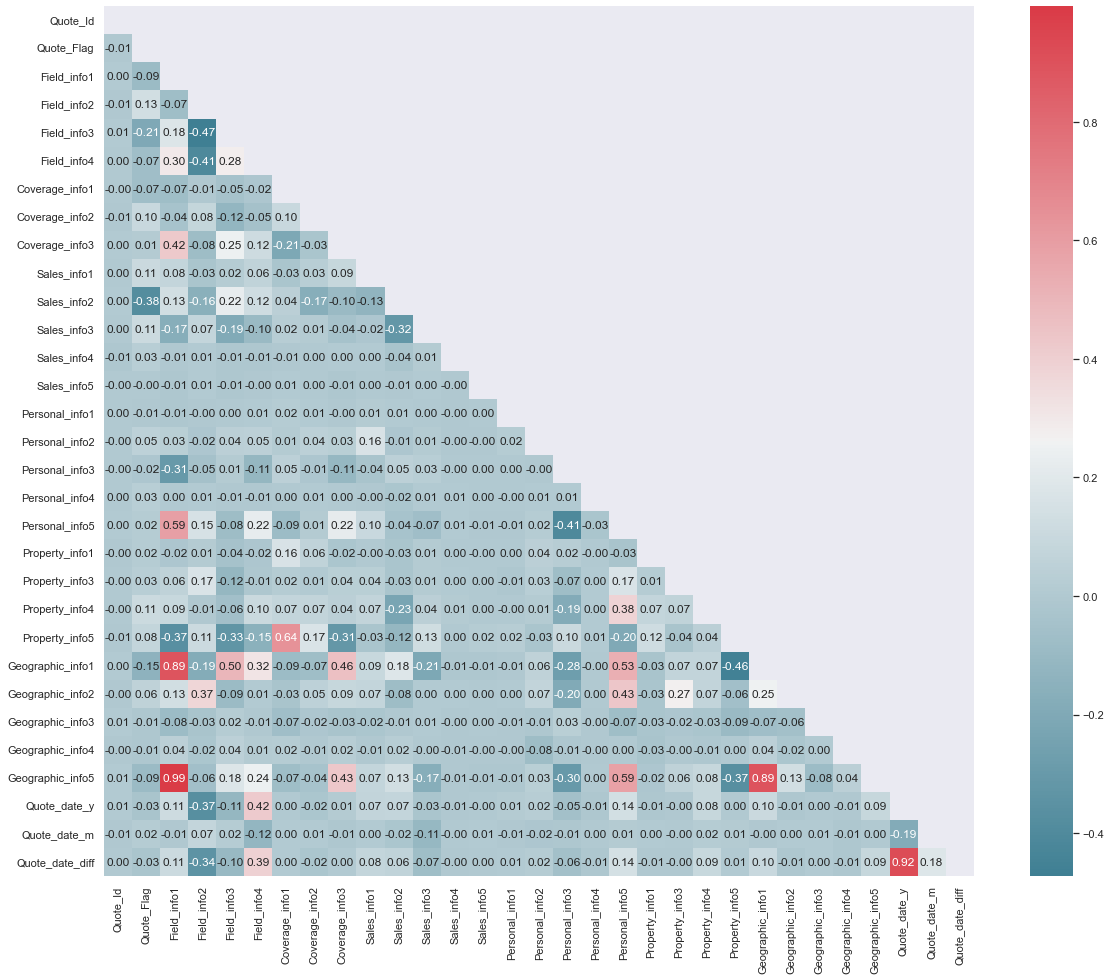

In [68]:
plt.figure(figsize=(20, 16))  
column = df.columns.tolist()  
mcorr = df[column].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True  
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

In [69]:
##看出相关程度较大的变量不少

### 特征初筛-相关系数

In [70]:
mcorr = mcorr.abs()
numerical_corr = mcorr[mcorr['Quote_Flag']>0.1]['Quote_Flag']
print(numerical_corr.sort_values(ascending=False))

index0 = numerical_corr.sort_values(ascending=False).index
print(df[index0].corr('spearman'))
index0 = numerical_corr.sort_values(ascending=False).index
features_corr = numerical_corr.sort_values(ascending=False).reset_index()
features_corr.columns = ['features_and_target', 'corr']
features_corr_select = features_corr[features_corr['corr']>0.1]
features1=list(features_corr_select['features_and_target'])

Quote_Flag          1.000000
Sales_info2         0.382545
Field_info3         0.207791
Geographic_info1    0.145177
Field_info2         0.129482
Property_info4      0.108489
Sales_info3         0.107781
Sales_info1         0.105348
Name: Quote_Flag, dtype: float64
                  Quote_Flag  Sales_info2  Field_info3  Geographic_info1  \
Quote_Flag          1.000000    -0.382545    -0.207791         -0.145177   
Sales_info2        -0.382545     1.000000     0.224284          0.180995   
Field_info3        -0.207791     0.224284     1.000000          0.500278   
Geographic_info1   -0.145177     0.180995     0.500278          1.000000   
Field_info2         0.129482    -0.159620    -0.472536         -0.185098   
Property_info4      0.108489    -0.229991    -0.062912          0.068936   
Sales_info3         0.107781    -0.319717    -0.192557         -0.210783   
Sales_info1         0.105348    -0.132954     0.018101          0.089752   

                  Field_info2  Property_info4  Sal

(43778, 8)
(18762, 8)
[21:05:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.051731
0:	learn: 0.5011061	total: 25.2ms	remaining: 25.2s
1:	learn: 0.3616954	total: 46ms	remaining: 22.9s
2:	learn: 0.2578934	total: 68.7ms	remaining: 22.8s
3:	learn: 0.1862541	total: 87.6ms	remaining: 21.8s
4:	learn: 0.1333591	total: 108ms	remaining: 21.4s
5:	learn: 0.0968402	total: 130ms	remaining: 21.5s
6:	learn: 0.0710489	total: 161ms	remaining: 22.8s
7:	learn: 0.0519542	total: 211ms	remaining: 26.1s
8:	learn: 0.0393445	total: 244ms	remaining: 26.8s
9:	learn: 0.0306863	total: 271ms	remaining: 26.8s
10:	learn: 0.0237504	total: 302ms	remaining: 27.2s
11:	learn: 0.0188282	total: 334ms	remaining: 27.5s
12:	learn: 0.0147941	total: 386ms	

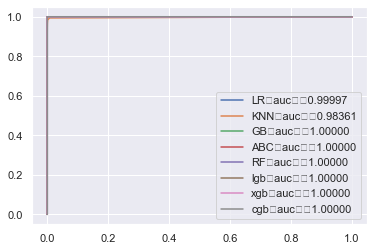

  names    scores  precisions   recalls       f1s      aucs
0    LR  0.999947    0.999726  1.000000  0.999863  0.999967
1   KNN  0.993391    0.998301  0.967609  0.982715  0.983606
2    GB  1.000000    1.000000  1.000000  1.000000  1.000000
3   ABC  1.000000    1.000000  1.000000  1.000000  1.000000
4    RF  1.000000    1.000000  1.000000  1.000000  1.000000
5   lgb  1.000000    1.000000  1.000000  1.000000  1.000000
6   xgb  1.000000    1.000000  1.000000  1.000000  1.000000
7   cgb  1.000000    1.000000  1.000000  1.000000  1.000000


In [71]:
X_corr=df.loc[:,features1]
#划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_corr,Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)
models = []
models.append(('LR', LogisticRegression(C=1e10, class_weight = 'balanced')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state = 42)))
models.append(('ABC', AdaBoostClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(class_weight = 'balanced')))
models.append(('lgb',lgb.LGBMClassifier()))
models.append(('xgb',xgb.XGBRFClassifier()))
models.append(('cgb',ctb.CatBoostClassifier()))
models.append
names = []
aucs=[]
scores=[]
precisions=[]
recalls=[]
f1s=[]
for name, model in models:
    #cv_results = model_selection.cross_val_score(estimator = model, X = X_train, 
    #                                             y = y_train, cv=kfold, scoring = scoring)
    
    model.fit(X_train, y_train)
    Y_pred_test = model.predict(X_test)
    score=model.score(X_test,y_test)
    scores.append(score)
    precision=precision_score(y_test,Y_pred_test)
    precisions.append(precision)
    recall=recall_score(y_test,Y_pred_test)
    recalls.append(recall)
    f1=f1_score(y_test,Y_pred_test)
    f1s.append(f1)
    fpr, tpr, thresholds= roc_curve(y_test,model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test,model.predict(X_test))
    aucs.append(auc)
    plt.plot(fpr, tpr, label='{}的auc值为{:.5f}'.format(name,auc))
    names.append(name)
    msg = "%s: score:%f (precision:%f,recall:%f)" % (name, score, precision, recall)
plt.legend(loc='lower right')
plt.show()
c={"names":names,"scores":scores,"precisions":precisions,"recalls":recalls,"f1s":f1s,"aucs":aucs}
result=pd.DataFrame(c)
print(result)

### 特征筛选-嵌入式

In [72]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rfe = RFE(lr)
rfe.fit(X, Y)
var = rfe.get_support(True)

In [73]:
var

array([ 0,  1,  3,  4,  7,  8, 12, 15, 16, 17, 19, 20, 21, 24],
      dtype=int64)

(43778, 14)
(18762, 14)
[21:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.051731
0:	learn: 0.6515904	total: 17.4ms	remaining: 17.4s
1:	learn: 0.6155894	total: 38.6ms	remaining: 19.3s
2:	learn: 0.5848535	total: 60.8ms	remaining: 20.2s
3:	learn: 0.5583997	total: 79ms	remaining: 19.7s
4:	learn: 0.5359921	total: 97.3ms	remaining: 19.4s
5:	learn: 0.5164190	total: 115ms	remaining: 19.1s
6:	learn: 0.4970394	total: 137ms	remaining: 19.5s
7:	learn: 0.4827494	total: 155ms	remaining: 19.3s
8:	learn: 0.4693184	total: 176ms	remaining: 19.4s
9:	learn: 0.4586837	total: 197ms	remaining: 19.5s
10:	learn: 0.4492555	total: 218ms	remaining: 19.6s
11:	learn: 0.4412440	total: 242ms	remaining: 19.9s
12:	learn: 0.4341399	total: 262

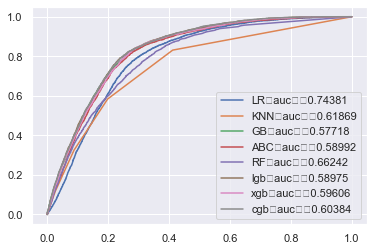

  names    scores  precisions   recalls       f1s      aucs
0    LR  0.739900    0.407728  0.750206  0.528320  0.743811
1   KNN  0.798156    0.471360  0.325281  0.384928  0.618689
2    GB  0.814039    0.562602  0.189953  0.284014  0.577184
3   ABC  0.808869    0.517453  0.231952  0.320318  0.589916
4    RF  0.792080    0.463559  0.450453  0.456912  0.662425
5   lgb  0.815478    0.563420  0.220697  0.317160  0.589745
6   xgb  0.813399    0.544045  0.240736  0.333777  0.596061
7   cgb  0.815531    0.553656  0.257755  0.351751  0.603843


In [74]:
X_Wrapper=X.iloc[:,var]
#划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Wrapper,Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)
##添加模型
models = []
models.append(('LR', LogisticRegression(C=1e10, class_weight = 'balanced')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state = 42)))
models.append(('ABC', AdaBoostClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(class_weight = 'balanced')))
models.append(('lgb',lgb.LGBMClassifier()))
models.append(('xgb',xgb.XGBRFClassifier()))
models.append(('cgb',ctb.CatBoostClassifier()))
models.append
names = []
aucs=[]
scores=[]
precisions=[]
recalls=[]
f1s=[]
for name, model in models:
    #cv_results = model_selection.cross_val_score(estimator = model, X = X_train, 
    #                                             y = y_train, cv=kfold, scoring = scoring)
    
    model.fit(X_train, y_train)
    Y_pred_test = model.predict(X_test)
    score=model.score(X_test,y_test)
    scores.append(score)
    precision=precision_score(y_test,Y_pred_test)
    precisions.append(precision)
    recall=recall_score(y_test,Y_pred_test)
    recalls.append(recall)
    f1=f1_score(y_test,Y_pred_test)
    f1s.append(f1)
    fpr, tpr, thresholds= roc_curve(y_test,model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test,model.predict(X_test))
    aucs.append(auc)
    plt.plot(fpr, tpr, label='{}的auc值为{:.5f}'.format(name,auc))
    names.append(name)
    msg = "%s: score:%f (precision:%f,recall:%f)" % (name, score, precision, recall)
plt.legend(loc='lower right')
plt.show()
c={"names":names,"scores":scores,"precisions":precisions,"recalls":recalls,"f1s":f1s,"aucs":aucs}
result=pd.DataFrame(c)
print(result)

In [75]:
# from sklearn.feature_selection import SelectKBest
# from minepy import MINE
# #由于MINE的设计不是函数式的，定义mic方法将其为函数式的，
# #返回一个二元组，二元组的第2项设置成固定的P值0.5
# def mic(x, y):
#     m = MINE()
#     m.compute_score(x, y)
#     return (m.mic(), 0.5)
# #参数k为选择的特征个数
# SelectKBest(lambda X, Y: array(map(lambda x:mic(x, Y), X.T)).T, k=2).fit_transform(X,Y)

### 特征筛选决策树度量方式

In [76]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# 获取数字特征重要性
importances = list(model.feature_importances_)
Columsname_list = list(X_train.columns)
feature_importances = [(feature, round(importance, 8)) for feature, importance in zip(Columsname_list, importances)]

In [77]:
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
fea_importances=pd.DataFrame(feature_importances,columns=['指标名称','贡献度'])

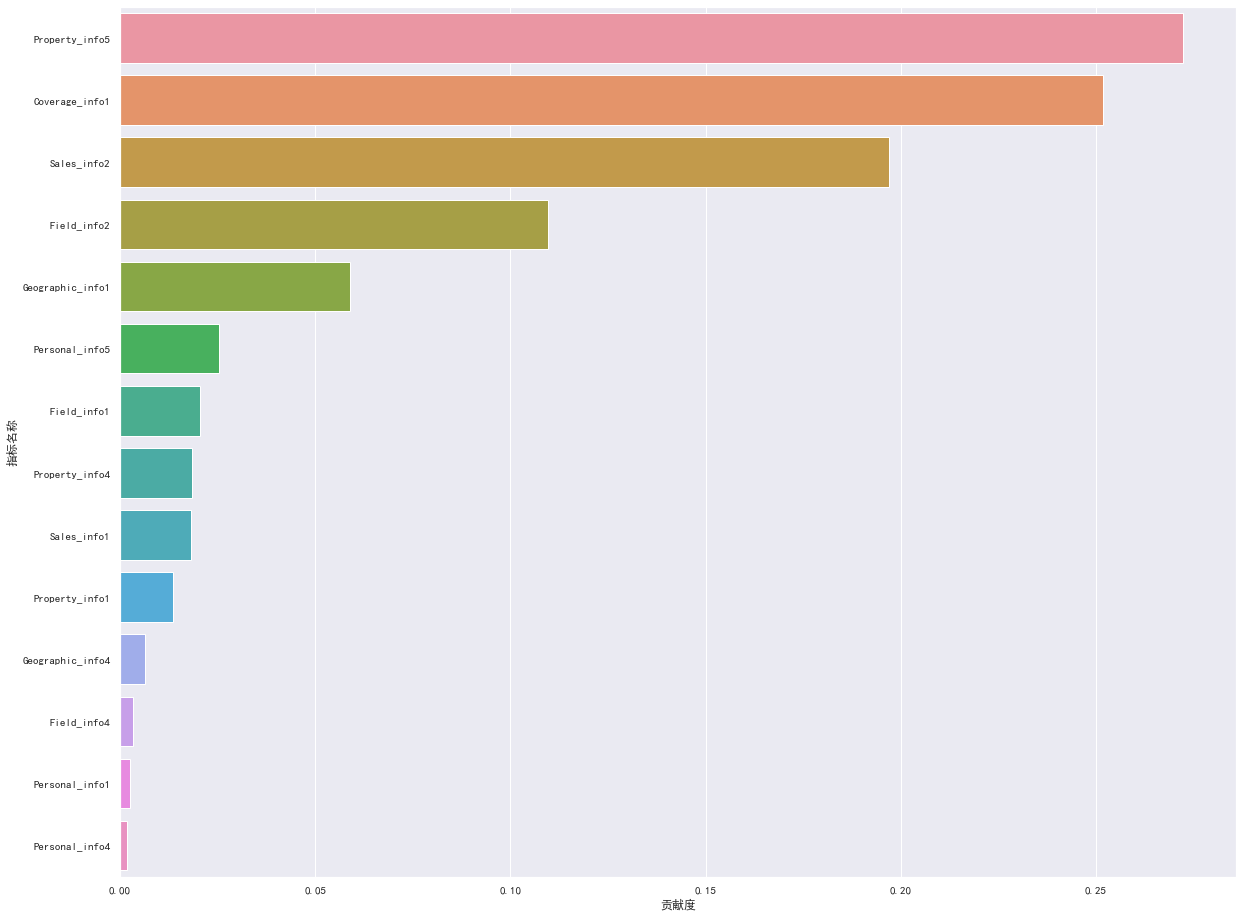

In [78]:
import matplotlib as mpl
ax=plt.subplots(figsize=(20,16))#调整画布
sns.barplot(x=fea_importances.loc[0:20,'贡献度'], y=fea_importances.loc[0:20,'指标名称'], data=fea_importances.loc[0:50,'贡献度'])
mpl.rcParams["font.sans-serif"]=["SimHei"]
mpl.rcParams["axes.unicode_minus"]=False

In [79]:
###　前２０特征　


(43778, 14)
(18762, 14)
[21:06:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.051731
0:	learn: 0.6518377	total: 18.6ms	remaining: 18.6s
1:	learn: 0.6165299	total: 38.6ms	remaining: 19.3s
2:	learn: 0.5858959	total: 55.9ms	remaining: 18.6s
3:	learn: 0.5614213	total: 70.2ms	remaining: 17.5s
4:	learn: 0.5380820	total: 87.1ms	remaining: 17.3s
5:	learn: 0.5183314	total: 107ms	remaining: 17.8s
6:	learn: 0.5014728	total: 121ms	remaining: 17.2s
7:	learn: 0.4860050	total: 144ms	remaining: 17.8s
8:	learn: 0.4728308	total: 163ms	remaining: 17.9s
9:	learn: 0.4617509	total: 185ms	remaining: 18.4s
10:	learn: 0.4511003	total: 207ms	remaining: 18.6s
11:	learn: 0.4425870	total: 227ms	remaining: 18.7s
12:	learn: 0.4353205	total: 2

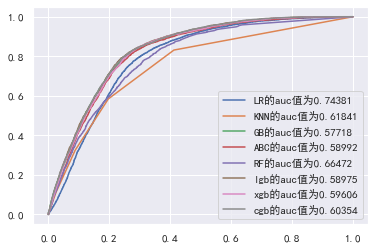

  names    scores  precisions   recalls       f1s      aucs
0    LR  0.739900    0.407728  0.750206  0.528320  0.743811
1   KNN  0.798049    0.470939  0.324732  0.384403  0.618415
2    GB  0.814039    0.562602  0.189953  0.284014  0.577184
3   ABC  0.808869    0.517453  0.231952  0.320318  0.589916
4    RF  0.792080    0.464007  0.456492  0.460219  0.664717
5   lgb  0.815478    0.563420  0.220697  0.317160  0.589745
6   xgb  0.813399    0.544045  0.240736  0.333777  0.596061
7   cgb  0.815052    0.550733  0.257755  0.351159  0.603545


In [80]:
X_Tree=df.loc[:,fea_importances.loc[0:20,'指标名称']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Tree,Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)
##添加模型
models = []
models.append(('LR', LogisticRegression(C=1e10, class_weight = 'balanced')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state = 42)))
models.append(('ABC', AdaBoostClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(class_weight = 'balanced')))
models.append(('lgb',lgb.LGBMClassifier()))
models.append(('xgb',xgb.XGBRFClassifier()))
models.append(('cgb',ctb.CatBoostClassifier()))
models.append
names = []
aucs=[]
scores=[]
precisions=[]
recalls=[]
f1s=[]
for name, model in models:
    #cv_results = model_selection.cross_val_score(estimator = model, X = X_train, 
    #                                             y = y_train, cv=kfold, scoring = scoring)
    
    model.fit(X_train, y_train)
    Y_pred_test = model.predict(X_test)
    score=model.score(X_test,y_test)
    scores.append(score)
    precision=precision_score(y_test,Y_pred_test)
    precisions.append(precision)
    recall=recall_score(y_test,Y_pred_test)
    recalls.append(recall)
    f1=f1_score(y_test,Y_pred_test)
    f1s.append(f1)
    fpr, tpr, thresholds= roc_curve(y_test,model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test,model.predict(X_test))
    aucs.append(auc)
    plt.plot(fpr, tpr, label='{}的auc值为{:.5f}'.format(name,auc))
    names.append(name)
    msg = "%s: score:%f (precision:%f,recall:%f)" % (name, score, precision, recall)
plt.legend(loc='lower right')
plt.show()
c={"names":names,"scores":scores,"precisions":precisions,"recalls":recalls,"f1s":f1s,"aucs":aucs}
result=pd.DataFrame(c)
print(result)

In [81]:
####这里由于时间原因，直接使用树模型的前20特征作为最终的特征
X=X_Tree

### StratifiedKFold切分数据(label均分)

In [82]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
# skf = StratifiedKFold(n_splits=5)
# for k, (train_index, test_index) in enumerate(skf.split(X, Y)):
#     X_train, X_test, y_train, y_test = X[], X[test_index], Y[train_index], Y[test_index]
#     clf = clf.fit(X_train, y_train)
#     print(k, clf.score(X_test, y_test))

In [ ]:
#时间问题先调那么多参数，就做一个随机森林的吧，太累啦

### 随机森林调参

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=0)

# model 
clf = RandomForestClassifier(n_jobs=-1)

# Set the parameters by cross-validation

tuned_parameters = {
                    'n_estimators': [50, 100, 200]
#                     ,'criterion': ['gini', 'entropy']
#                     ,'max_depth': [2, 5]
#                     ,'max_features': ['log2', 'sqrt', 'int']
#                     ,'bootstrap': [True, False]
#                     ,'warm_start': [True, False]
                    }

scores = ['precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(clf, tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 200}

Grid scores on development set:

0.655 (+/-0.012) for {'n_estimators': 50}
0.656 (+/-0.013) for {'n_estimators': 100}
0.656 (+/-0.015) for {'n_estimators': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     35439
           1       0.46      0.35      0.40      8339

    accuracy                           0.80     43778
   macro avg       0.66      0.63      0.64     43778
weighted avg       0.78      0.80      0.79     43778




### 随机森林模型混淆矩阵

Confusion matrix, without normalization
[[11452  1220]
 [ 1880  1083]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.63 0.37]]


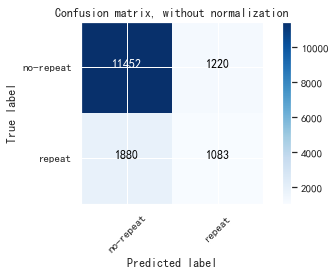

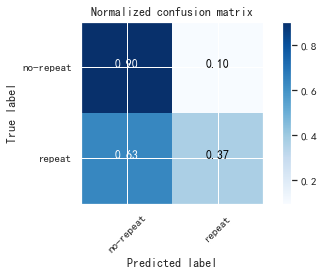

In [84]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# label name
class_names = ['no-repeat', 'repeat']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [85]:
import lightgbm

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = lightgbm

train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)
params = {
          'boosting_type': 'gbdt',
          #'boosting_type': 'dart',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'min_child_weight': 1.5,
          'num_leaves': 2**5,
          'lambda_l2': 10,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'learning_rate': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2,
          'silent': True,
          }
num_round = 10000
early_stopping_rounds = 100
model = clf.train(params, 
                  train_matrix,
                  num_round,
                  valid_sets=test_matrix,
                  early_stopping_rounds=early_stopping_rounds)
Y_pred_test= model.predict(X_test,num_iteration=model.best_iteration)

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 37524, number of used features: 14
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score -0.212942
[LightGBM] [Info] Start training from score -1.651316
[1]	valid_0's multi_logloss: 0.482253
Training until validation sc

### VOTE模型投票

In [86]:
from sklearn import datasets 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(X)
y = Y

clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.79 (+/- 0.00) [Logistic Regression]
Accuracy: 0.79 (+/- 0.01) [Random Forest]
Accuracy: 0.76 (+/- 0.01) [naive Bayes]
Accuracy: nan (+/- nan) [Ensemble]


## 大杀器 autogluon

In [87]:
df2 = pd.read_csv(".\数据集\TrainingData.csv", header=0)
df2

,Quote_Id,Quote_Date,Quote_Flag,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,...,Property_info1,Property_info2,Property_info3,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5
0,2,14/5/14,0,B,0.9153,935,N,5,2,D,...,N,0,D,1,6,2,13,-1,N,CA
1,3,19/6/13,0,J,0.9691,"1,165",N,5,22,F,...,N,0,D,1,8,14,7,-1,N,TX
2,6,6/2/15,0,B,0.9153,935,N,6,22,D,...,N,0,D,1,11,2,12,-1,N,CA
3,9,15/10/14,0,J,0.8793,"1,113",N,1,22,F,...,N,0,O,0,1,14,6,-1,N,TX
4,10,30/3/15,1,F,1.0101,548,N,13,22,E,...,N,0,R,1,25,4,22,-1,N,NJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,104296,28/6/13,0,F,0.9919,564,N,4,25,J,...,N,0,R,1,16,4,17,-1,N,NJ
62576,104297,25/1/14,0,F,0.9838,548,N,13,2,E,...,N,0,R,1,18,4,19,-1,N,NJ
62577,104299,24/1/14,0,B,0.9403,935,N,7,22,E,...,N,0,D,0,24,2,8,-1,N,CA
62578,104300,7/12/14,0,J,0.8870,"1,113",N,15,25,G,...,N,0,J,1,23,14,5,-1,N,TX


In [88]:
train_data=df2.sample(frac=0.7)#按0.7比例随机采样
test_data=df2[~df2.index.isin(train_data.index)]
train_data

,Quote_Id,Quote_Date,Quote_Flag,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,...,Property_info1,Property_info2,Property_info3,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5
33609,55860,30/4/13,0,B,0.9403,965,N,7,22,E,...,N,0,O,1,7,2,13,-1,N,CA
400,652,10/11/14,0,E,0.9108,"1,487",N,8,22,A,...,Y,0,S,1,14,9,25,-1,N,IL
53488,89114,6/2/14,0,B,0.9403,935,N,20,22,D,...,N,0,D,0,24,1,10,-1,N,CA
30453,50601,5/6/13,1,J,0.9691,"1,165",N,5,22,F,...,N,0,S,1,12,17,4,-1,N,TX
52524,87561,24/3/15,1,B,0.9153,935,N,9,22,E,...,N,0,O,1,8,2,11,-1,N,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44278,73895,30/6/14,0,B,0.9153,935,N,25,22,D,...,N,0,A,1,20,2,7,-1,N,CA
39620,66095,7/5/15,0,B,0.9153,935,N,3,2,E,...,N,0,O,1,4,2,10,-1,N,CA
18774,31307,16/10/14,0,J,0.8793,"1,113",N,24,22,G,...,Y,0,J,1,17,24,13,-1,N,TX
25889,43079,24/4/15,0,B,0.9153,935,N,14,22,D,...,Y,0,D,1,24,2,7,-1,N,CA


In [89]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)

In [90]:
label="Quote_Flag"
metric='roc_auc'
predictor = TabularPredictor(label, 
                             eval_metric=metric,
                            ).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20220529_130828\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220529_130828\"
AutoGluon Version:  0.4.1
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    43806
Train Data Columns: 29
Label Column: Quote_Flag
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5203.71 MB
	Train Data (Original)  Memory Usage: 36.91 MB (0.7% of available memory)
	Inferring data type of ea

[1000]	valid_set's binary_logloss: 0.308809


	0.8897	 = Validation score   (roc_auc)
	7.54s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM ...
	0.9087	 = Validation score   (roc_auc)
	4.05s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.8988	 = Validation score   (roc_auc)
	6.03s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9032	 = Validation score   (roc_auc)
	7.11s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: CatBoost ...
	0.9101	 = Validation score   (roc_auc)
	310.22s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.8865	 = Validation score   (roc_auc)
	3.96s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.8891	 = Validation score   (roc_auc)
	3.99s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 7: early stopping
	0.8933	 = Validation score   (roc_a

In [91]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.909026,0.913161,4.460083,0.842745,437.156947,0.014961,0.001994,4.091200,2,True,14
1,CatBoost,0.906469,0.910129,0.070975,0.042887,310.217102,0.070975,0.042887,310.217102,1,True,7
2,LightGBMLarge,0.906080,0.908071,0.270278,0.053857,3.951437,0.270278,0.053857,3.951437,1,True,13
3,XGBoost,0.904913,0.907222,0.157579,0.035904,3.481692,0.157579,0.035904,3.481692,1,True,11
4,LightGBM,0.904256,0.908748,0.347071,0.078789,4.047183,0.347071,0.078789,4.047183,1,True,4
5,RandomForestEntr,0.898277,0.903182,0.476724,0.222405,7.114985,0.476724,0.222405,7.114985,1,True,6
6,RandomForestGini,0.896998,0.898781,0.476725,0.188496,6.030880,0.476725,0.188496,6.030880,1,True,5
7,NeuralNetFastAI,0.890006,0.893285,0.410901,0.076796,101.892096,0.410901,0.076796,101.892096,1,True,10
8,NeuralNetTorch,0.888131,0.895327,0.539560,0.156581,92.693249,0.539560,0.156581,92.693249,1,True,12
9,LightGBMXT,0.886799,0.889690,0.462763,0.080780,7.540845,0.462763,0.080780,7.540845,1,True,3
